<a href="https://colab.research.google.com/github/cabamarcos/VA_1/blob/main/pruebas_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from PIL import Image
from google.colab import files
import requests

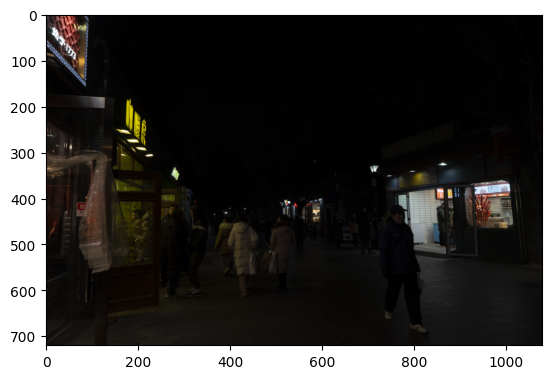

In [87]:
img = cv2.imread('images/2543.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

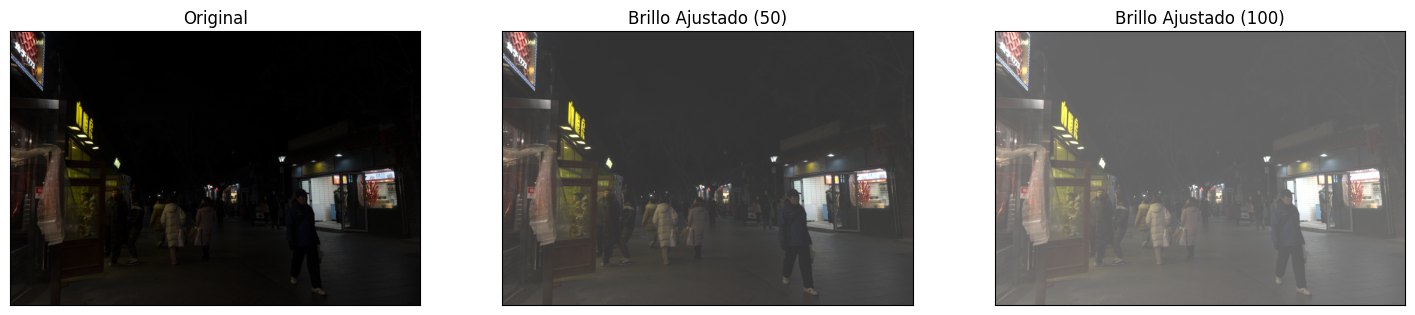

In [88]:
brillo = 50
brillo_ajustado = cv2.add(img, np.full(img.shape, brillo, dtype=np.uint8))
brillo = 100
brillo_ajustado_15 = cv2.add(img, np.full(img.shape, brillo, dtype=np.uint8))

# Crea una figura con tres subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Ajusta el tamaño de la figura

# Muestra la imagen original
axes[0].imshow(img)
axes[0].set_title('Original')
axes[0].set_xticks([])
axes[0].set_yticks([])

# Muestra la imagen con brillo ajustado (factor 1.2)
axes[1].imshow(brillo_ajustado)
axes[1].set_title('Brillo Ajustado (50)')
axes[1].set_xticks([])
axes[1].set_yticks([])

# Muestra la imagen con brillo ajustado (factor 1.5)
axes[2].imshow(brillo_ajustado_15)
axes[2].set_title('Brillo Ajustado (100)')
axes[2].set_xticks([])
axes[2].set_yticks([])

plt.show()

 lo que estás modificando son los valores de intensidad de los píxeles en los tres canales de color (B, G, R) de la imagen.

 Como vemos, si es verdad que un poco de brillo hace que se vea mejor, pero mucho brillo hace que se saturen los píxeles, ya uqe llegan a un valor cercano a 255.

 Vamos a utilizar otras operaciones.


# Procesado del histograma


In [89]:
# Función para calcular y mostrar histograma y CDF
def mostrar_histograma_e_cdf(imagen, titulo):
    hist, bins = np.histogram(imagen.flatten(), 256, [0, 256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * float(hist.max()) / cdf.max()

    plt.plot(cdf_normalized, color = 'b')
    plt.hist(img.flatten(), bins=256, color='gray', alpha=0.9)
    plt.title(titulo)
    plt.xlabel("Intensidad")
    plt.ylabel("Frecuencia")
    plt.legend(["CDF", "Histograma"])
    plt.show();

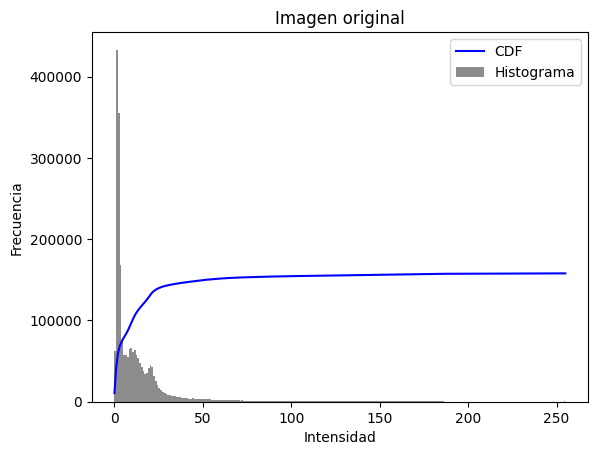

In [90]:
#grayscale
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
mostrar_histograma_e_cdf(gray_img, "Imagen original")

Como podemos ver tenemos una imagen que claramente es muy oscura ya que el 60% de los píxeles están en el quinto de valores más oscuros.

Para mejorar esta imagen, podremos hacer una ecualización del histograma, haciendo que los valores se repartan más equitativamente por el histograma.



## Ecualización del histograma


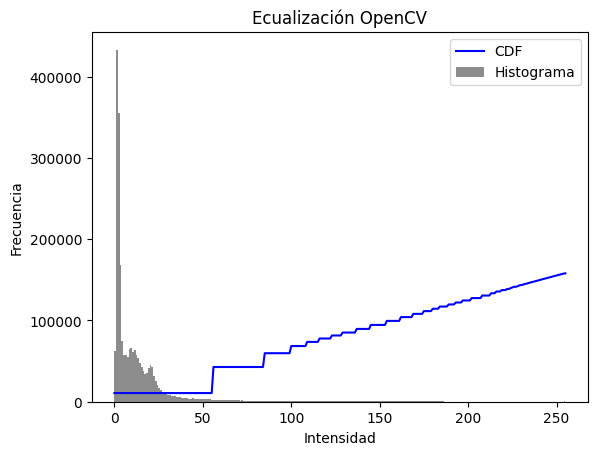

In [91]:
# Ecualizar la imagen utilizando OpenCV
equalized_image_cv2 = cv2.equalizeHist(gray_img)

mostrar_histograma_e_cdf(equalized_image_cv2, "Ecualización OpenCV")

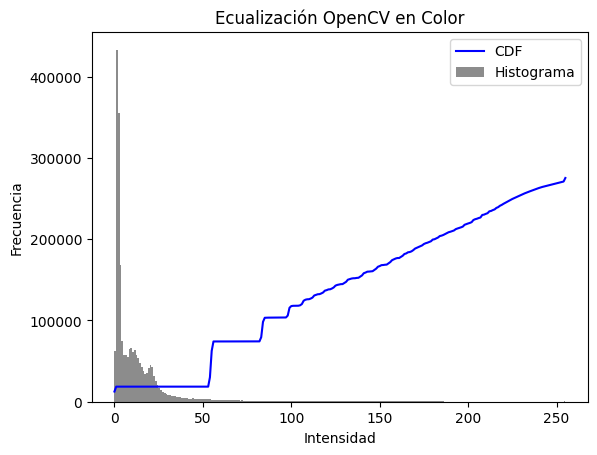

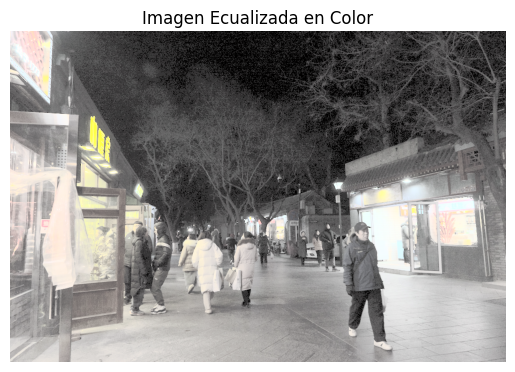

In [92]:
# Ecualizar la imagen utilizando OpenCV en cada canal de color
img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV) # Convierte a YUV para ecualizar solo la luminancia (Y)
img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0]) # Ecualiza el canal Y
equalized_image_cv2_color = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB) # Convierte de nuevo a RGB

mostrar_histograma_e_cdf(equalized_image_cv2_color, "Ecualización OpenCV en Color")

# Display the equalized image in color
plt.figure()
plt.imshow(equalized_image_cv2_color) # Muestra la imagen ecualizada en color
plt.title("Imagen Ecualizada en Color")
plt.axis('off')
plt.show()

Se puede observar que la imagen ha sido mejorada pero tiene mucho ruido. Además podemos ver que la imagen tiene saturación en las fuentes de luz.

Para mejorar estom vamos a usar CLAHE, ya que divide las imágenes en porciones, ecualizando de forma separada.

## CLAHE

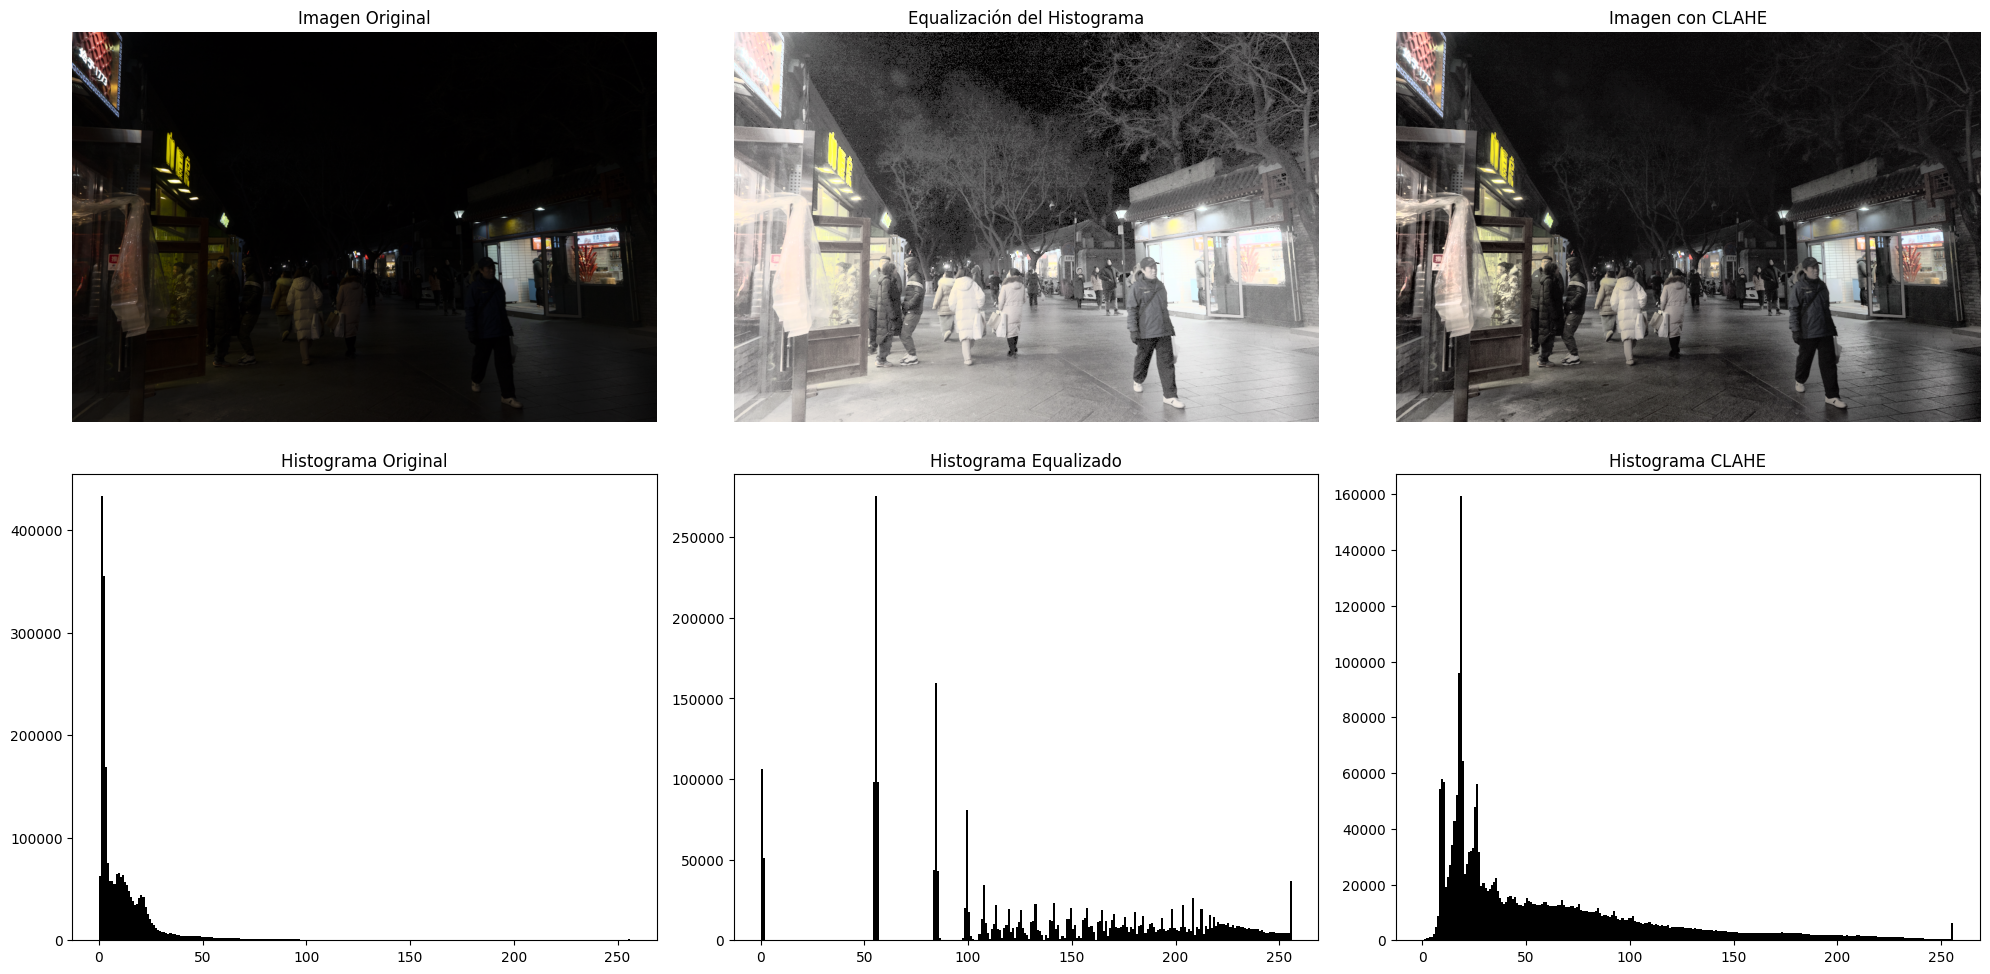

In [93]:
img = cv2.imread('images/2543.png') # Load the image in color (BGR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  #If needed convert to RGB
img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)  # Convert to YUV for luminance equalization

clahe = cv2.createCLAHE(clipLimit=8.0, tileGridSize=(8, 8))
img_yuv[:,:,0] = clahe.apply(img_yuv[:,:,0])
img_clahe_color = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)  # Para LAB: cv2.COLOR_LAB2BGR


# Mostrar imágenes y sus histogramas
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# Imagen original
img = cv2.imread('images/2543.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
axes[0, 0].imshow(img)
axes[0, 0].set_title("Imagen Original")
axes[0, 0].axis('off')
axes[1, 0].hist(img.ravel(), bins=256, range=(0, 256), color='black')
axes[1, 0].set_title("Histograma Original")

# Imagen con equalización del histograma
axes[0, 1].imshow(equalized_image_cv2_color, cmap='gray')
axes[0, 1].set_title("Equalización del Histograma")
axes[0, 1].axis('off')
axes[1, 1].hist(equalized_image_cv2_color.ravel(), bins=256, range=(0, 256), color='black')
axes[1, 1].set_title("Histograma Equalizado")

# Imagen con CLAHE

axes[0, 2].imshow(img_clahe_color, cmap='gray')
axes[0, 2].set_title("Imagen con CLAHE")
axes[0, 2].axis('off')
axes[1, 2].hist(img_clahe_color.ravel(), bins=256, range=(0, 256), color='black')
axes[1, 2].set_title("Histograma CLAHE")

plt.tight_layout()
plt.show()

Aunque se ve bien, vamos a probar otras formas

# GAMMA correction

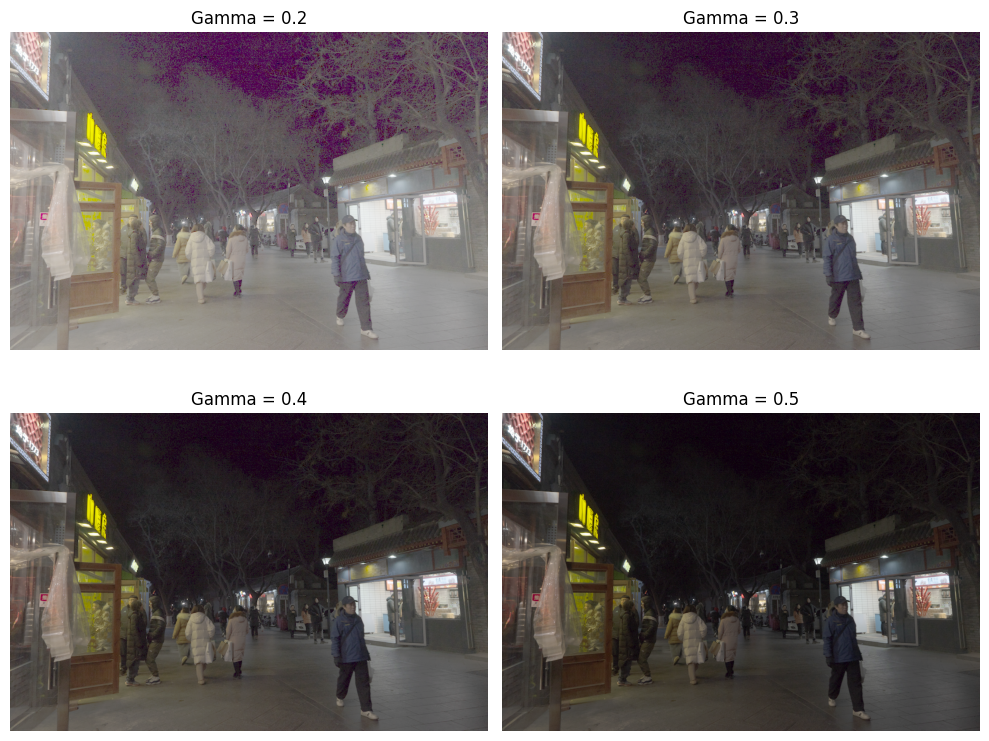

In [109]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Cargar la imagen en color (BGR)
img = cv2.imread('images/2543.png')  # Ruta de tu imagen

# Verifica que la imagen se cargó correctamente
if img is None:
    print("Error al cargar la imagen.")
    exit()

# Convertir a RGB para visualizar correctamente en Matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Lista de valores gamma a aplicar (solo 0.2, 0.3, y 0.4)
gamma_values = [0.2, 0.3, 0.4, 0.5]

# Crear una figura para mostrar las imágenes
plt.figure(figsize=(10, 8))

# Mostrar la imagen original como la primera
plt.subplot(2, 2, 1)  # (n_filas, n_columnas, índice)
plt.title("Imagen Original")
# plt.imshow(img_rgb)
plt.axis('off')

# Normalizar la imagen al rango [0, 1] para realizar operaciones gamma
normalized_img = img_rgb / 255.0

# Aplicar corrección gamma y mostrar las imágenes transformadas
for i, gamma in enumerate(gamma_values, start=1):  # Comienza en el índice 2
    # Aplicar transformación gamma a cada canal de color
    gamma_corrected = np.power(normalized_img, gamma) * 255

    # Asegurarse de convertir el resultado a uint8
    gamma_corrected = gamma_corrected.astype(np.uint8)

    # Mostrar la imagen transformada en la cuadrícula
    plt.subplot(2, 2, i)  # (n_filas, n_columnas, índice)
    plt.title(f"Gamma = {gamma}")
    plt.imshow(gamma_corrected)
    plt.axis('off')

# Ajustar el diseño y mostrar las imágenes
plt.tight_layout()
plt.show()


Podemos ver que la imagen mejora bastante sin saturar ni quemar los píxeles en rangos de 0,4 y 0,5.

# Log transform

In [110]:
def adjust_brightness_log(img, c):
    """Ajusta el brillo de la imagen utilizando una función logarítmica."""
    img = img.astype(np.float32) / 255.0
    for i in range(3):
        img[:,:,i] = c * np.log(1 + img[:,:,i])
    img = np.clip(img, 0, 1) * 255
    img = img.astype(np.uint8)
    return img


img = cv2.imread('images/2543.png')  # Ruta de tu imagen
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

log_img = adjust_brightness_log(img, 6)

plt.imshow(log_img)

